In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pysal as ps
import pysal.viz as viz
import esda
from spreg import OLS
from spreg import ML_Error
from spreg import ML_Lag
import statsmodels.api as sm
from libpysal.weights import Queen
import mapclassify
import libpysal as lps
from sklearn.metrics import mean_squared_error as mse

# Prepare the Dataset

In [43]:
lsoa=gpd.read_file('data/lsoa_IMD_airbnb_housing/lsoa_IMD_airbnb_housing.shp')
lsoa.drop(columns=['Value','Year','Measure','LSOA11NM','Mean Price','Small Host','Multiple L','Property C'],inplace=True)
lsoa

Code                       Area  USUALRES  HHOLDRES  COMESTRES  \
0     E01000001        City of London 001A      1465      1465          0   
1     E01000002        City of London 001B      1436      1436          0   
2     E01000003        City of London 001C      1346      1250         96   
3     E01000005        City of London 001E       985       985          0   
4     E01000006  Barking and Dagenham 016A      1703      1699          4   
...         ...                        ...       ...       ...        ...   
4830  E01033742             Greenwich 007F      1352      1352          0   
4831  E01033743             Greenwich 002H      2038      2038          0   
4832  E01033744             Greenwich 007G      1845      1728        117   
4833  E01033745             Greenwich 002I      1820      1820          0   
4834  E01033746             Greenwich 038E      1464      1436         28   

      POPDEN  HHOLDS  AVHHOLDSZ  IMDScore  IncScore  EmpScore  EduScore  \
0      112.9     876        1.7       6.2       0.0       0.0       0.0   
1       62.9     830        1.7       5.1       0.0       0.0       0.1   
2      227.7     817        1.5      19.4       0.1       0.1       5.8   
3       52.0     467        2.1      28.7       0.2       0.1      22.3   
4      116.2     543        3.1      19.8       0.1       0.1      14.8   
...      ...     ...        ...       ...       ...       ...       ...   
4830   107.6     581        2.3      13.1       0.1       0.0       7.8   
4831    20.4     663        3.1      21.0       0.1       0.1       9.2   
4832   125.8     646        2.7      29.4       0.2       0.1      17.9   
4833    32.3     591        3.1      22.1       0.2       0.1       9.8   
4834   115.3     715        2.0      21.8       0.1       0.1       6.4   

      HeaScore  CriScore  BaHScore  EnvScore  \
0         -1.7      -2.0      29.5      31.9   
1         -1.1      -2.3      24.4      23.1   
2         -0.1      -1.0      40.1      40.5   
3         -0.1      -1.3      39.9      29.0   
4         -0.4      -0.1      45.2      26.9   
...        ...       ...       ...       ...   
4830      -0.4      -0.2      40.5      12.5   
4831      -0.2       0.2      50.3      11.9   
4832       0.9       0.4      37.3      14.2   
4833      -0.2      -0.3      45.1      14.8   
4834      -0.4       0.7      24.0      45.7   

                                               geometry  
0     POLYGON ((532105.330 182017.386, 532162.728 18...  
1     POLYGON ((532747.048 181793.042, 532671.921 18...  
2     POLYGON ((532135.385 182204.275, 532158.489 18...  
3     POLYGON ((533808.170 180773.910, 533649.287 18...  
4     POLYGON ((545122.084 184321.013, 545271.951 18...  
...                                                 ...  
4830  POLYGON ((544642.760 179830.773, 544766.392 17...  
4831  POLYGON ((546579.271 181103.898, 546687.117 18...  
4832  POLYGON ((544536.564 179453.221, 544602.707 17...  
4833  POLYGON ((546415.827 180158.362, 546320.798 18...  
4834  POLYGON ((538140.138 177319.110, 538129.314 17...  

[4835 rows x 17 columns]

In [44]:
# calculate the crime
crime = gpd.read_file('data/crime_ldn_202007.shp')
grouped = crime.groupby(by = ['LSOA code'])
crime_number = grouped.aggregate({'Crime ID':np.size})
lsoa1 = lsoa.merge(crime_number,left_on='Code', right_on='LSOA code',how='left')
lsoa1.rename(columns={'Crime ID' : 'crime_number'}, inplace=True)
lsoa1=lsoa1.fillna(value = 0)
lsoa1

Code                       Area  USUALRES  HHOLDRES  COMESTRES  \
0     E01000001        City of London 001A      1465      1465          0   
1     E01000002        City of London 001B      1436      1436          0   
2     E01000003        City of London 001C      1346      1250         96   
3     E01000005        City of London 001E       985       985          0   
4     E01000006  Barking and Dagenham 016A      1703      1699          4   
...         ...                        ...       ...       ...        ...   
4830  E01033742             Greenwich 007F      1352      1352          0   
4831  E01033743             Greenwich 002H      2038      2038          0   
4832  E01033744             Greenwich 007G      1845      1728        117   
4833  E01033745             Greenwich 002I      1820      1820          0   
4834  E01033746             Greenwich 038E      1464      1436         28   

      POPDEN  HHOLDS  AVHHOLDSZ  IMDScore  IncScore  EmpScore  EduScore  \
0      112.9     876        1.7       6.2       0.0       0.0       0.0   
1       62.9     830        1.7       5.1       0.0       0.0       0.1   
2      227.7     817        1.5      19.4       0.1       0.1       5.8   
3       52.0     467        2.1      28.7       0.2       0.1      22.3   
4      116.2     543        3.1      19.8       0.1       0.1      14.8   
...      ...     ...        ...       ...       ...       ...       ...   
4830   107.6     581        2.3      13.1       0.1       0.0       7.8   
4831    20.4     663        3.1      21.0       0.1       0.1       9.2   
4832   125.8     646        2.7      29.4       0.2       0.1      17.9   
4833    32.3     591        3.1      22.1       0.2       0.1       9.8   
4834   115.3     715        2.0      21.8       0.1       0.1       6.4   

      HeaScore  CriScore  BaHScore  EnvScore  \
0         -1.7      -2.0      29.5      31.9   
1         -1.1      -2.3      24.4      23.1   
2         -0.1      -1.0      40.1      40.5   
3         -0.1      -1.3      39.9      29.0   
4         -0.4      -0.1      45.2      26.9   
...        ...       ...       ...       ...   
4830      -0.4      -0.2      40.5      12.5   
4831      -0.2       0.2      50.3      11.9   
4832       0.9       0.4      37.3      14.2   
4833      -0.2      -0.3      45.1      14.8   
4834      -0.4       0.7      24.0      45.7   

                                               geometry  crime_number  
0     POLYGON ((532105.330 182017.386, 532162.728 18...          19.0  
1     POLYGON ((532747.048 181793.042, 532671.921 18...          27.0  
2     POLYGON ((532135.385 182204.275, 532158.489 18...           3.0  
3     POLYGON ((533808.170 180773.910, 533649.287 18...          45.0  
4     POLYGON ((545122.084 184321.013, 545271.951 18...           8.0  
...                                                 ...           ...  
4830  POLYGON ((544642.760 179830.773, 544766.392 17...           6.0  
4831  POLYGON ((546579.271 181103.898, 546687.117 18...          14.0  
4832  POLYGON ((544536.564 179453.221, 544602.707 17...          14.0  
4833  POLYGON ((546415.827 180158.362, 546320.798 18...          12.0  
4834  POLYGON ((538140.138 177319.110, 538129.314 17...          14.0  

[4835 rows x 18 columns]

In [45]:
# calculate the pubs number nearby for each lsoa
pubs = gpd.read_file('data/London_Pubs/London_Pubs.shp')
pubs = pubs.to_crs({'init': 'epsg:27700'})
N = []
for i in range(len(lsoa1)):
    buff = lsoa1['geometry'][i].buffer(200) # add a buffer for each lsoa
    pub_nearby = pubs[pubs.geometry.within (buff)]
    n = len(pub_nearby)
    N.append(n)
lsoa1['pubs_number_buffer'] = pd.DataFrame(N)
lsoa1

C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Code                       Area  USUALRES  HHOLDRES  COMESTRES  \
0     E01000001        City of London 001A      1465      1465          0   
1     E01000002        City of London 001B      1436      1436          0   
2     E01000003        City of London 001C      1346      1250         96   
3     E01000005        City of London 001E       985       985          0   
4     E01000006  Barking and Dagenham 016A      1703      1699          4   
...         ...                        ...       ...       ...        ...   
4830  E01033742             Greenwich 007F      1352      1352          0   
4831  E01033743             Greenwich 002H      2038      2038          0   
4832  E01033744             Greenwich 007G      1845      1728        117   
4833  E01033745             Greenwich 002I      1820      1820          0   
4834  E01033746             Greenwich 038E      1464      1436         28   

      POPDEN  HHOLDS  AVHHOLDSZ  IMDScore  IncScore  EmpScore  EduScore  \
0      112.9     876        1.7       6.2       0.0       0.0       0.0   
1       62.9     830        1.7       5.1       0.0       0.0       0.1   
2      227.7     817        1.5      19.4       0.1       0.1       5.8   
3       52.0     467        2.1      28.7       0.2       0.1      22.3   
4      116.2     543        3.1      19.8       0.1       0.1      14.8   
...      ...     ...        ...       ...       ...       ...       ...   
4830   107.6     581        2.3      13.1       0.1       0.0       7.8   
4831    20.4     663        3.1      21.0       0.1       0.1       9.2   
4832   125.8     646        2.7      29.4       0.2       0.1      17.9   
4833    32.3     591        3.1      22.1       0.2       0.1       9.8   
4834   115.3     715        2.0      21.8       0.1       0.1       6.4   

      HeaScore  CriScore  BaHScore  EnvScore  \
0         -1.7      -2.0      29.5      31.9   
1         -1.1      -2.3      24.4      23.1   
2         -0.1      -1.0      40.1      40.5   
3         -0.1      -1.3      39.9      29.0   
4         -0.4      -0.1      45.2      26.9   
...        ...       ...       ...       ...   
4830      -0.4      -0.2      40.5      12.5   
4831      -0.2       0.2      50.3      11.9   
4832       0.9       0.4      37.3      14.2   
4833      -0.2      -0.3      45.1      14.8   
4834      -0.4       0.7      24.0      45.7   

                                               geometry  crime_number  \
0     POLYGON ((532105.330 182017.386, 532162.728 18...          19.0   
1     POLYGON ((532747.048 181793.042, 532671.921 18...          27.0   
2     POLYGON ((532135.385 182204.275, 532158.489 18...           3.0   
3     POLYGON ((533808.170 180773.910, 533649.287 18...          45.0   
4     POLYGON ((545122.084 184321.013, 545271.951 18...           8.0   
...                                                 ...           ...   
4830  POLYGON ((544642.760 179830.773, 544766.392 17...           6.0   
4831  POLYGON ((546579.271 181103.898, 546687.117 18...          14.0   
4832  POLYGON ((544536.564 179453.221, 544602.707 17...          14.0   
4833  POLYGON ((546415.827 180158.362, 546320.798 18...          12.0   
4834  POLYGON ((538140.138 177319.110, 538129.314 17...          14.0   

      pubs_number_buffer  
0                     18  
1                     32  
2                      6  
3                     36  
4                      0  
...                  ...  
4830                   0  
4831                   1  
4832                   0  
4833                   0  
4834                  10  

[4835 rows x 19 columns]

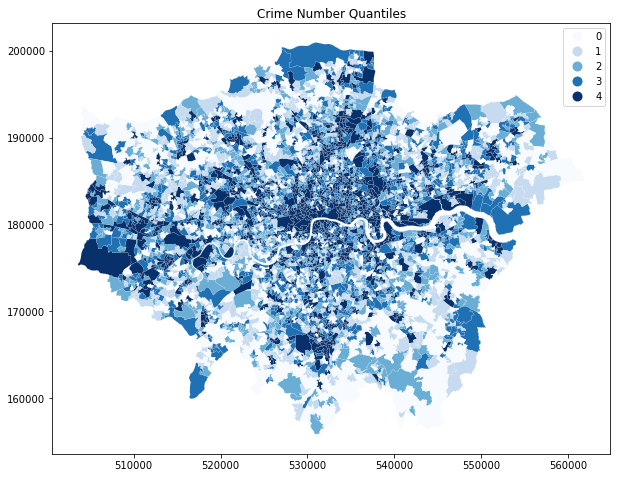

In [70]:
# plot the crime quantiles map
pr = ps.viz.mapclassify.Quantiles(lsoa1['crime_number'], k=5)
f, ax = plt.subplots(1, figsize=(10, 8))
lsoa1.assign(cl_pr=pr.yb).plot(column='cl_pr', categorical=True, k=5, cmap='Blues',
                               linewidth=0.1, ax=ax, edgecolor='white', legend=True)

plt.title('Crime Number Quantiles')
plt.show()

# OLS Regression

In [47]:
# calculate the VIF
X = lsoa1[['pubs_number_buffer','POPDEN','IMDScore','IncScore','EmpScore','EduScore']]
X[7]=1
variance_inflation_factor(X.values, 1)

C:\Users\Lock\AppData\Local\Temp\ipykernel_13584\379828222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[7]=1


1.2244237008343404

In [49]:
y = np.array(lsoa1['crime_number'])
y.shape = (len(y), 1)
# value for independent variables into a one dimmensional array X.
# You can feel free to change the independant variables
X = []
X.append(lsoa1['pubs_number_buffer'])
X.append(lsoa1['POPDEN'])
X.append(lsoa1['IMDScore'])
X.append(lsoa1['IncScore'])
X.append(lsoa1['EmpScore'])
X.append(lsoa1['EduScore'])
X = np.array(X).T

In [50]:
ols = OLS(y, X, name_y='Crime number', name_x=['Pubs Number','Population Density','Deprivation','Income','Employment', 'Education'], name_ds='LSOA', white_test=True)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :        LSOA
Weights matrix      :        None
Dependent Variable  :Crime number                Number of Observations:        4835
Mean dependent var  :     21.3541                Number of Variables   :           7
S.D. dependent var  :     21.3761                Degrees of Freedom    :        4828
R-squared           :      0.4326
Adjusted R-squared  :      0.4319
Sum squared residual: 1253292.973                F-statistic           :    613.5024
Sigma-square        :     259.588                Prob(F-statistic)     :           0
S.E. of regression  :      16.112                Log likelihood        :  -20296.183
Sigma-square ML     :     259.213                Akaike info criterion :   40606.367
S.E of regression ML:     16.1001                Schwarz criterion     :   40651.752

-----------------------------------------------------------------------------

In [52]:
x = ['pubs_number_buffer','POPDEN','IMDScore','IncScore','EmpScore', 'EduScore']
X = lsoa1.loc[:, x].dropna()
y = np.array(lsoa1['crime_number'])
X = sm.add_constant(X) ## add an intercept (beta_0)
# Note the difference in argument order
model_c = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model_c.predict(X)
# Print out the statistics
print(model_c.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     613.5
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:52:25   Log-Likelihood:                -20296.
No. Observations:                4835   AIC:                         4.061e+04
Df Residuals:                    4828   BIC:                         4.065e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.5418      0

C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# Spatial Weights

C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future ver

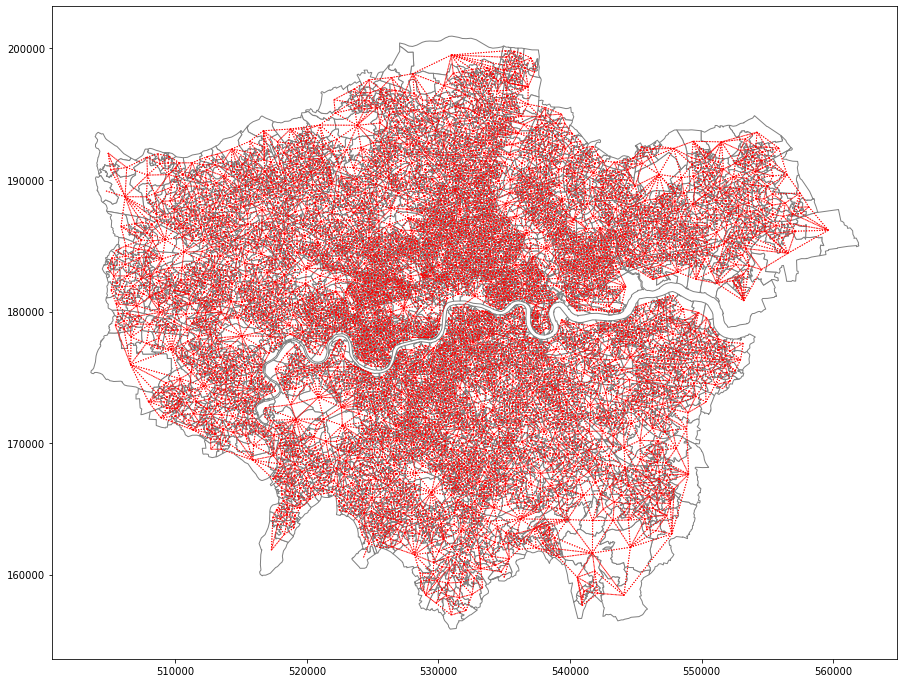

In [57]:
w_queen = Queen.from_dataframe(lsoa1)
ax = lsoa1.plot(edgecolor='grey', facecolor='w', figsize=(20, 12))
f,ax = w_queen.plot(lsoa1, ax=ax,
                    edge_kws=dict(color='r', linestyle=':', linewidth=1),
                    node_kws=dict(marker=''))

# Spatial Lag

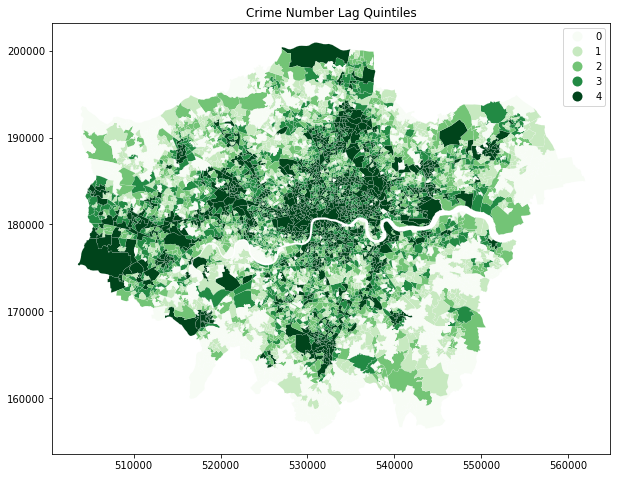

In [60]:
crime_Lag = lps.weights.lag_spatial(w_queen, lsoa1['crime_number']) #spatial lag of the variable
crime_LagQ5 = mapclassify.Quantiles(crime_Lag, k=5)
f, ax = plt.subplots(1, figsize=(10, 8))
lsoa1.assign(cl_lag=crime_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='Greens', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Crime Number Lag Quintiles')
plt.show()

# Moran Plot

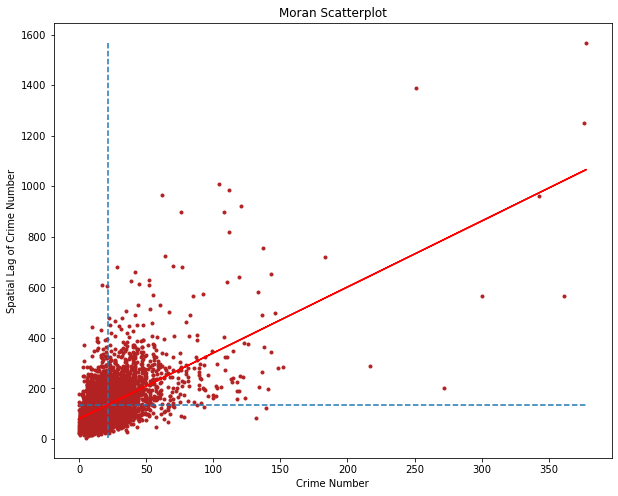

In [61]:
crime = lsoa1['crime_number']
b,a = np.polyfit(crime, crime_Lag, 1)
f, ax = plt.subplots(1, figsize=(10, 8))
plt.plot(crime, crime_Lag, '.', color='firebrick')

# dashed vert at mean of the last year's private rent level
plt.vlines(crime.mean(), crime_Lag.min(), crime_Lag.max(), linestyle='--')
# dashed horizontal at mean of lagged private rent
plt.hlines(crime_Lag.mean(), crime.min(), crime.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(crime, a + b*crime, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Crime Number')
plt.xlabel('Crime Number')
plt.show()

# Global Spatial Autocorrelation

<AxesSubplot:>

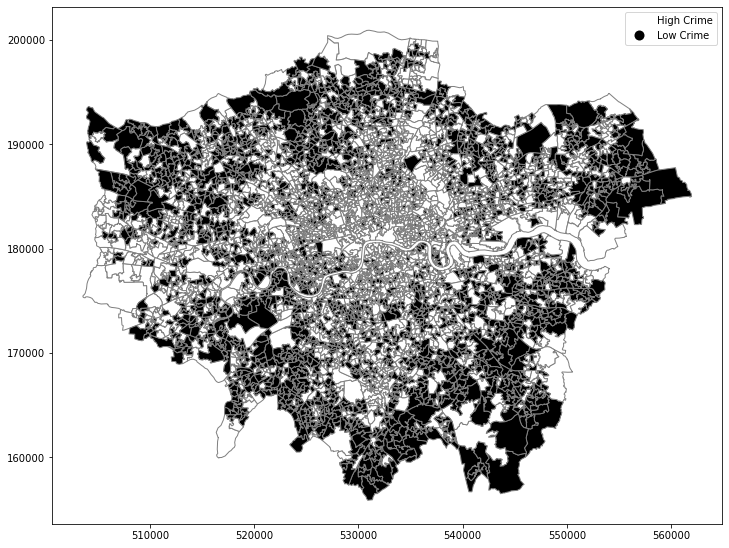

In [62]:
lsoa1['crime_number'].median()
binary = lsoa1['crime_number'] > lsoa1['crime_number'].median()
labels = ['Low Crime', 'High Crime']
binary = [labels[i] for i in 1 * binary]
lsoa1['binary'] = binary
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()
lsoa1.plot(column='binary', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [63]:
mi = esda.Moran(lsoa1['crime_number'], w_queen, two_tailed=False)
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.3586 
The Expected Value for Statistic I is: -0.0002 
The Significance Test Value is: 0.0000


# Spatial Regression

In [66]:
y = np.array(lsoa1['crime_number'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X.
# You can feel free to change the independant variables
X= []
X.append(lsoa1['pubs_number_buffer'])
X.append(lsoa1['POPDEN'])
X.append(lsoa1['IMDScore'])
X.append(lsoa1['IncScore'])
X.append(lsoa1['EmpScore'])
X.append(lsoa1['EduScore'])
X = np.array(X).T

In [67]:
spat_lag = ML_Lag(y,X,w_queen,name_y='crime_rate',name_x=['Pubs Number','Population Density','Deprivation','Income','Employment', 'Education'], name_ds='LSOA')
print(spat_lag.summary)

C:\Users\Lock\anaconda3\envs\msda2021\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :        LSOA
Weights matrix      :     unknown
Dependent Variable  :  crime_rate                Number of Observations:        4835
Mean dependent var  :     21.3541                Number of Variables   :           8
S.D. dependent var  :     21.3761                Degrees of Freedom    :        4827
Pseudo R-squared    :      0.4500
Spatial Pseudo R-squared:  0.4237
Sigma-square ML     :     251.291                Log likelihood        :  -20236.436
S.E of regression   :      15.852                Akaike info criterion :   40488.871
                                                 Schwarz criterion     :   40540.741

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [68]:
spat_err = ML_Error(y,X,w_queen, name_y='crime_rate',name_x=['Pubs Number','Population Density','Deprivation','Income','Employment', 'Education'], name_ds='LSOA')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :        LSOA
Weights matrix      :     unknown
Dependent Variable  :  crime_rate                Number of Observations:        4835
Mean dependent var  :     21.3541                Number of Variables   :           7
S.D. dependent var  :     21.3761                Degrees of Freedom    :        4828
Pseudo R-squared    :      0.4311
Sigma-square ML     :     243.017                Log likelihood        :  -20181.453
S.E of regression   :      15.589                Akaike info criterion :   40376.905
                                                 Schwarz criterion     :   40422.290

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [69]:
mses = pd.Series({'OLS': mse(y, ols.predy.flatten()),
                  'SL': mse(y, spat_lag.predy.flatten()),
                  'SE': mse(y, spat_err.predy.flatten())
                  })
mses.sort_values()

SL     251.290896
OLS    259.212611
SE     260.002844
dtype: float64

# Geographically Weighted Regression

In [18]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

In [19]:
# Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)


centroidseries = lsoa1['geometry'].centroid
u, v = [list(t) for t in zip(*map(getXY, centroidseries))]
coords = list(zip(u, v))
#Prepare dataset inputs
g_y = lsoa1['crime_number'].values.reshape((-1, 1))
g_X = lsoa1[['pubs_number_buffer', 'POPDEN', 'IMDScore', 'IncScore', 'EmpScore', 'EduScore']].values
g_coords = list(zip(u, v))
# Standardised our data to have mean of 0 and standard deviation of 1 (this standardisation is important so we have normal distribution)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1, 1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# Building our model by assigning adaptive bandwidth
bw = Sel_BW(g_coords,
            g_y,  # Independent variable
            g_X,  # Dependent variable
            fixed=False,  # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True)  # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)
#Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2743.371
Log-likelihood:                                                   -5490.585
AIC:                                                              10995.171
AICc:                                                             10997.201
BIC:                                                             -38215.626
R2:                                                                   0.433
Adj. R2:                                                              0.432

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

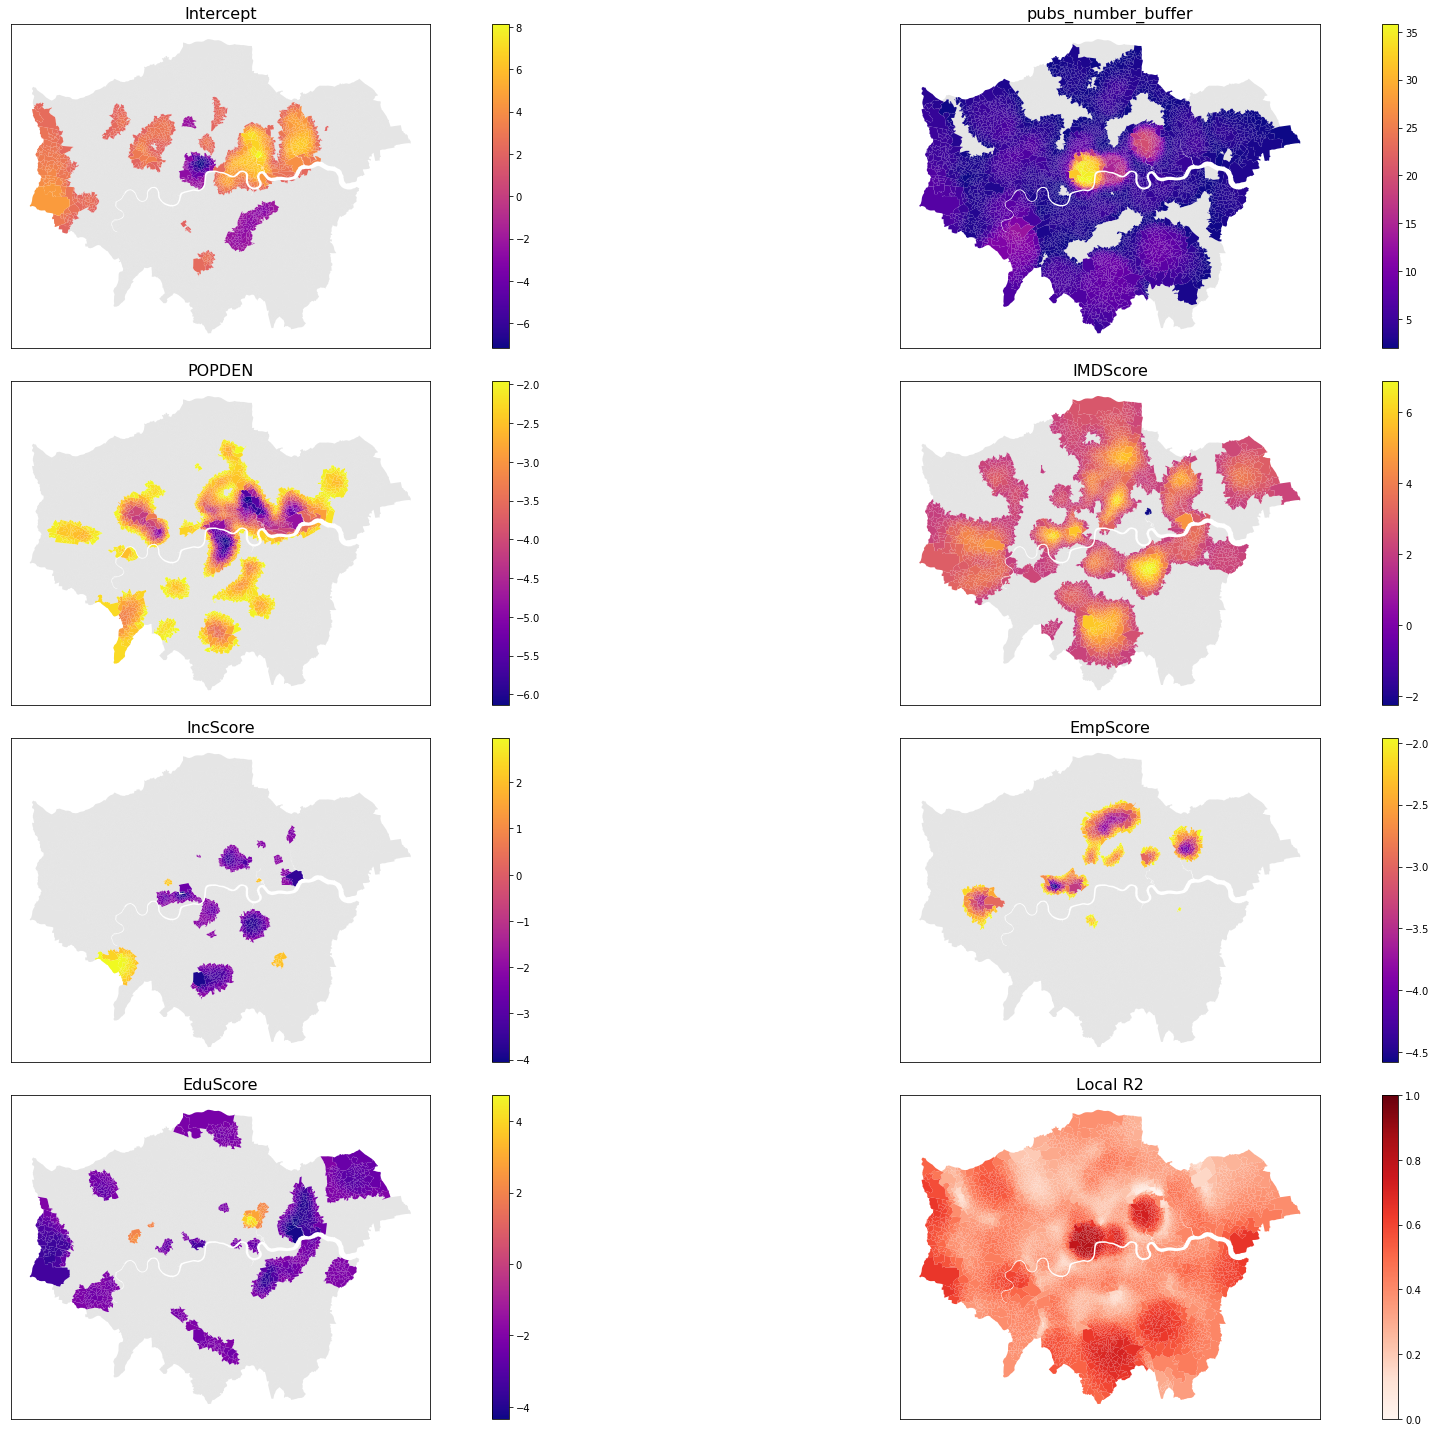

In [20]:
filtered_estimates = results.filter_tvals(alpha=.05)
# Convert arrays to data frame
lsoa1_params = pd.DataFrame(filtered_estimates)
lsoa1_localR2 = pd.DataFrame(results.localR2)
# Create the new dataframe
df1 = pd.DataFrame(lsoa1['Code'])
df2 = df1.assign(intercept=lsoa1_params[0],
                 pub_number_estimate=lsoa1_params[1],
                 POPDEN_estimate=lsoa1_params[2],
                 Deprivation_estimate=lsoa1_params[3],
                 Income_estimate=lsoa1_params[4],
                 Environment_estimate=lsoa1_params[5],
                 Education_estimate=lsoa1_params[6],
                 localR2=lsoa1_localR2[0])
data_final = lsoa1.merge(df2, left_on='Code', right_on='Code')

# First, let's create empty set of subplots with 2 rows and 3 columns
f, ax = plt.subplots(4, 2, figsize=(30, 20), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept', 'pubs_number_buffer', 'POPDEN', 'IMDScore', 'IncScore', 'EmpScore', 'EduScore']

# Here, we are creating loop for our parameter estimates
for i, row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    data_temp = data_final.assign(toplot=filtered_estimates.T[i])
    (data_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey', ax=ax[i], alpha=.2))

    # and assign colours only to the significant estimates
    (data_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))

    ax[i].set_title(titles[i], fontsize=16)

    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# For the last one, local R2, we can just map all of them regarding the significance

(data_final.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds'))

ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])

ax[-1].set_title('Local R2', fontsize=16)

f.tight_layout()

plt.show()